In [630]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import seaborn as sns
import scipy.sparse
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from random import shuffle
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC, SVC
from gensim.models import word2vec
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
import torch

In [631]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [632]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

Using cuda device


In [633]:
#import gc
#gc.collect() 
#torch.cuda.empty_cache()

In [634]:
session_length = 15
session_dilation = 10

In [635]:
def GetActualSites(path, session_length, session_dilation,  user_threshold=0.75, sites_threshold = 500):
    """
    Функция которая парсит все файлы и собирает bag_of_sites, строит гистограмму сайтов, а также гистограмму сайтов с порогом по 
    количеству встреч этого сайта, чтобы не учитывать сайты которые встретились 1 раз.
    
    """
    a = os.listdir(path)
    full_session_length = session_length + session_dilation
    if ('.DS_Store' in a):
        a.remove('.DS_Store')
    sites = []
    for file in a:
        user_sites = np.array(pd.read_csv(path + file)['site'])
        sites.extend(user_sites[: full_session_length * int(len(user_sites) // full_session_length * user_threshold + 1)])
    sites = np.array(sites)    
    bag_of_sites = set(sites)
    bag_of_sites = {site : [i, 0] for i, site in enumerate(bag_of_sites)}
    index = 0
    for site in tqdm(bag_of_sites):
        cnt = (sites == site).sum()
        bag_of_sites[site][1] = cnt
    values = []
    for site in bag_of_sites:
        values.append(bag_of_sites[site][1])
    values = np.array(values) 
    
    sns.displot(values, log_scale=2).set(title='sites distribution')
    sns.displot(values[values > sites_threshold], log_scale=2).set(title='thresholded sites distribution')
    
    bag_of_actual_sites = {}
    for site in bag_of_sites:
        if (bag_of_sites[site][1] >= sites_threshold):
            bag_of_actual_sites[site] = bag_of_sites[site][0]
    return bag_of_sites, bag_of_actual_sites        
  

In [636]:
def SplitSessions(history, timestamp, session_length=10, session_dilation=10):
    """
    Функция которая разбивает файлы на сессии фиксированной длины и ширины окна
    
    """
    index = 0 # конец последней сессии
    max_ind = len(history)
    sessions = []
    timestamps = []
    while(index <= max_ind - session_length):
        new_session = []
        new_timestamps = []
        for ind in range(session_length):
            new_session.append(history[index + ind])
            new_timestamps.append(timestamp[index + ind])
        sessions.append(new_session)
        timestamps.append(new_timestamps)
        index += session_dilation
    return np.array(sessions), np.array(timestamps)

In [637]:
def GetUsersSessions(path, bag_of_actual_sites, session_length=10, user_threshold=0.75, session_dilation=10):
    """
    Функция собирает из bag_of_sites и заспличенных сессий датасеты
    
    """
    a = os.listdir(path)
    if ('.DS_Store' in a):
        a.remove('.DS_Store')
    
    print('Files done:')
    all_sessions_train, all_sessions_test, all_timestamps_train = [], [], []
    all_timestamps_test, train_targets, test_targets = [], [], []
    for ind, file in enumerate(tqdm(a)):
        user_history = np.array(pd.read_csv(path + file)['site'])
        user_timestamp = np.array(pd.read_csv(path + file)['timestamp'])
        flag = False
        sessions, session_timestamps = SplitSessions(user_history, user_timestamp, session_length, session_dilation)
        max_ind = int(len(sessions) * user_threshold)
        for index, session in enumerate(sessions):
            new_session = []
            if (index == len(sessions) - 1 and flag):
                break
            for site in session:
                if (site in bag_of_actual_sites):
                    new_session.append(bag_of_actual_sites[site])  
                else:
                    new_session.append(-1)
            if (index <= max_ind):
                train_targets.append(ind)
                all_sessions_train.append(new_session)
                all_timestamps_train.append(session_timestamps[index])
            else:
                test_targets.append(ind)
                all_sessions_test.append(new_session)
                all_timestamps_test.append(session_timestamps[index])
    return all_sessions_train, all_sessions_test, all_timestamps_train, all_timestamps_test, np.array(train_targets), np.array(test_targets)      

In [638]:
def MakeTimeFeatures(timestamps):
    """
    Функция добавляет в качестве признаков временные метки у timestamp'ов сайтов
    
    """
    global session_length
    string_type = "%Y-%m-%d %H:%M:%S"
    columns = ['month', 'day', 'hour', 'minute', 'second', 'dayofweek']
    new_timestamps = []
    
    features_dict = {'month': [],
            'day': [],
            'hour': [],
            'minute': [],
            'second': [],
            'dayofweek': [],
            'partofday': [],
            'average_time': [],
           }
    
    for timestamp in tqdm(timestamps):
        new_timestamp = []
        previous_time = None
        average_time = 0
        for time in timestamp:
            time_vector = []
            day_parts = [0] * 4
            part_of_day = 0
            new_time = datetime.strptime(time, string_type)
            new_time = pd.to_datetime([new_time])[0]
            for col in columns:
                if col == 'hour':
                    hour = getattr(new_time, 'hour')
                    if hour < 10 and hour >= 6:
                        part_of_day = 1
                    elif hour < 18 and hour >= 10:
                        part_of_day = 2
                    elif hour < 23 and hour >= 18:
                        part_of_day = 3
                features_dict[col].append(getattr(new_time, col))        
                time_vector.append(getattr(new_time, col))
            if previous_time != None:
                new_timestamp.append((new_time - previous_time).seconds)
                average_time += (new_time - previous_time).total_seconds()
                features_dict['average_time'].append(average_time)
            previous_time = new_time
            features_dict['partofday'].append(part_of_day)
            day_parts[part_of_day] = 1
            time_vector.extend(day_parts)
            new_timestamp.extend(time_vector)
        new_timestamp.append(average_time / session_length)    
        new_timestamps.append(new_timestamp)
    return new_timestamps, features_dict    

In [639]:
def MakeOneHotDataFrameFromSessions(sessions, timestamps, bag_of_actual_sites):
    """
    Функция собирает one-hot вектора по сессии
    
    """
    data = []
    new_timestamps, features_dict = MakeTimeFeatures(timestamps)
    for session_index, session in enumerate(tqdm(sessions)):
        one_hot = [0] * (len(bag_of_actual_sites) + 1)
        for index, site_ind in enumerate(session):
            if site_ind == -1:
                one_hot[-1] += 1
            else:
                one_hot[site_ind] += 1
        one_hot.extend(new_timestamps[session_index])        
        data.append(one_hot)
    return csr_matrix(data), features_dict

In [640]:
class mean_vectorizer():
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [641]:
def MakeDataFrameFromSessions(sessions, timestamps, bag_of_actual_sites):
    """
    Подход с эмбеддингами word2vec
    
    """
    data = []
    #columns = [f'site{i}' for i in range(len(sessions[0]))]
    #columns.append('user_id')
    new_timestamps = MakeTimeFeatures(timestamps)
    for ind, session in enumerate(tqdm(sessions)):
        one_hot = [0] * (len(sessions[0]))
        for index, site_ind in enumerate(session):
            one_hot[index] = site_ind
        #one_hot[-1] = targets[ind]
        #one_hot.extend(new_timestamps[ind])
        data.append(one_hot)
    model = word2vec.Word2Vec(data, vector_size=300, window=3, workers=4)
    w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
    data_mean=np.array(mean_vectorizer(w2v).fit(data).transform(data))
    times = np.array(new_timestamps)
    times = (times - np.mean(times, axis = 0)) / np.std(times, axis=0)
    return csr_matrix(np.concatenate((data_mean, times), axis=1))

In [642]:
def CountMetrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Balanced accuracy score : {balanced_accuracy_score(y_true, y_pred)}')
    x = f1_score(y_true, y_pred, average='macro')
    print(f'F1 : {x}')

In [644]:
path = './capstone_user_identification/150users/'

In [645]:
def MakeData(path, session_length, session_dilation, sites_threshold=-1):
    """
    Функция возвращает train/test датасеты
    """
    all_bag_of_sites, bag_of_actual_sites = GetActualSites(path, sites_threshold = sites_threshold,
                                                      session_length=session_length, session_dilation=session_dilation)

    for index, site in enumerate(bag_of_actual_sites):
        bag_of_actual_sites[site] = index  
    
    train_sessions, test_sessions, train_timestamps, test_timestamps, train_targets, test_targets = GetUsersSessions(path,
                                                                              bag_of_actual_sites,
                                                                              session_length=session_length,
                                                                              session_dilation=session_dilation)
    
    train_data, train_features_times = MakeOneHotDataFrameFromSessions(train_sessions, train_timestamps, bag_of_actual_sites)
    test_data, test_features_times = MakeOneHotDataFrameFromSessions(test_sessions, test_timestamps, bag_of_actual_sites)
    assert train_data.shape[0] == train_targets.shape[0]
    assert test_data.shape[0] == test_targets.shape[0]
    
    #shuffled_train, train_targets = ShuffleSparseData(train_data, train_targets)
    #shuffled_train.toarray(), train_targets
    #assert(shuffled_train.shape[0] == train_targets.shape[0])
    
    return train_data, train_targets, test_data, test_targets, train_features_times

  0%|          | 0/23109 [00:00<?, ?it/s]

Files done:


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/102702 [00:00<?, ?it/s]

  0%|          | 0/102702 [00:00<?, ?it/s]

  0%|          | 0/34110 [00:00<?, ?it/s]

  0%|          | 0/34110 [00:00<?, ?it/s]

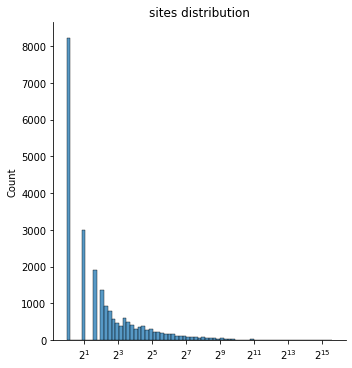

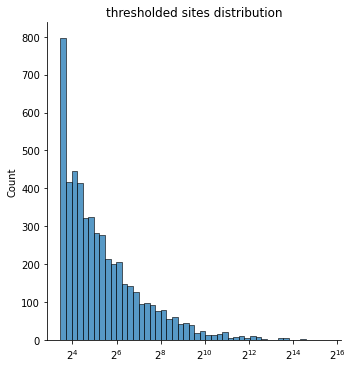

In [646]:
train_data, train_targets, test_data, test_targets, train_features_times = MakeData(path, session_length, session_dilation, sites_threshold=10)

Визуализируем полученные признаки

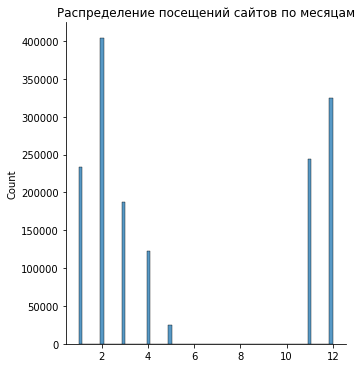

In [647]:
sns.displot(train_features_times['month']).set(title='Распределение посещений сайтов по месяцам')

Из графика видно, что нам предоставлены данные с ноября по май, в феврале особенная активность

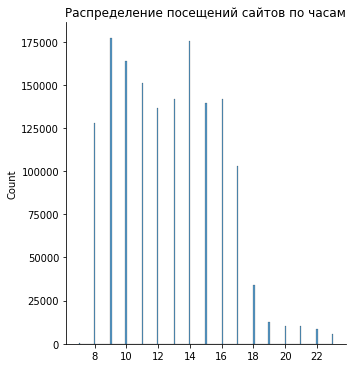

In [648]:
sns.displot(train_features_times['hour']).set(title='Распределение посещений сайтов по часам')

Ожидаемо в первой половине дня активность намного выше, ближе к ночи активность падает

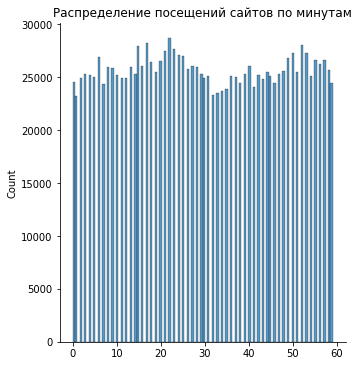

In [649]:
sns.displot(train_features_times['minute']).set(title='Распределение посещений сайтов по минутам')

Распределение по минутам близко к равномерному

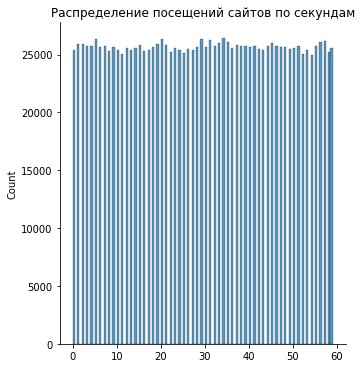

In [650]:
sns.displot(train_features_times['second']).set(title='Распределение посещений сайтов по секундам')

Распределение по секундам получилось почти равномерным, как и ожидалось

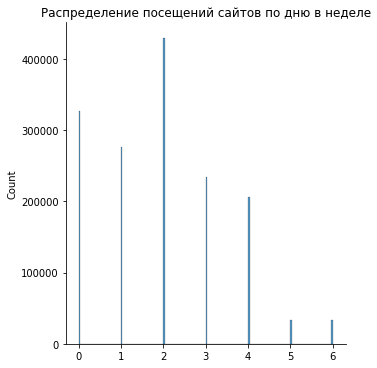

In [651]:
sns.displot(train_features_times['dayofweek']).set(title='Распределение посещений сайтов по дню в неделе')

Из графика видно, что в середине недели активность пользователей выше

Построение моделей:

In [652]:
trd = normalize(train_data, axis=0)
testrd = normalize(test_data, axis = 0)
# (52691, 17554)

In [653]:
new_train = csr_matrix(scipy.sparse.hstack((trd, train_targets[:, None])))
new_train

<102702x5640 sparse matrix of type '<class 'numpy.float64'>'
	with 12282283 stored elements in Compressed Sparse Row format>

In [654]:
index = np.arange(np.shape(new_train)[0])
np.random.shuffle(index)
train = new_train[index]

targets = np.squeeze(train[:, -1].toarray())

Логистическая регрессия

In [655]:
lr = LogisticRegression(max_iter = 5000)
lr.fit(train[:,:-1], targets)

preds = lr.predict(testrd)
CountMetrics(test_targets, preds)

Accuracy score : 0.2128701260627382
Balanced accuracy score : 0.11871828835267292
F1 : 0.13156275071962328


SVM

In [656]:
lrc = LinearSVC(C = 1, max_iter = 5000)
lrc.fit(train[:,:-1], targets)

preds = lrc.predict(testrd)
CountMetrics(test_targets, preds)

Accuracy score : 0.30351802990325416
Balanced accuracy score : 0.22873374192710377
F1 : 0.22847991560922873


CatBoost

In [657]:
cb = CatBoostClassifier(depth = 2, l2_leaf_reg = 7, thread_count = 14, iterations = 1000, verbose = 100)
cb.fit(train_data, train_targets, eval_set=(test_data, test_targets))

preds = cb.predict(test_data)
new_preds = [pred[0] for pred in preds]
CountMetrics(test_targets, new_preds)

0:	learn: 4.9674230	test: 4.9506117	best: 4.9506117 (0)	total: 1.01s	remaining: 16m 50s
100:	learn: 4.2265304	test: 4.4581111	best: 4.4581111 (100)	total: 1m 39s	remaining: 14m 42s
200:	learn: 3.9296975	test: 4.3258069	best: 4.3258069 (200)	total: 3m 16s	remaining: 13m 2s
300:	learn: 3.7675089	test: 4.2617613	best: 4.2617613 (300)	total: 4m 57s	remaining: 11m 30s
400:	learn: 3.6286059	test: 4.2122296	best: 4.2122296 (400)	total: 7m 23s	remaining: 11m 2s
500:	learn: 3.5219456	test: 4.1768358	best: 4.1768358 (500)	total: 9m 31s	remaining: 9m 29s
600:	learn: 3.4547437	test: 4.1486578	best: 4.1486578 (600)	total: 11m 9s	remaining: 7m 24s
700:	learn: 3.3649706	test: 4.1219638	best: 4.1219638 (700)	total: 12m 46s	remaining: 5m 26s
800:	learn: 3.2991496	test: 4.0946481	best: 4.0946481 (800)	total: 14m 21s	remaining: 3m 33s
900:	learn: 3.2366841	test: 4.0730093	best: 4.0730093 (900)	total: 15m 56s	remaining: 1m 45s
999:	learn: 3.1810049	test: 4.0495259	best: 4.0495259 (999)	total: 17m 30s	rema

Бустинг показал себя хуже всего, в целом, это было ожидаемо. Все наши данные имеют вид разреженных эмбеддингов, на таких данных обычно лучше всего себя показывают линейные модели, потому что значения конкретного признака в эмбеддингах не так важны, а деревья пытаються сплитить данные по значениям конкретных фичей

Лучший результат показала SVM, попробуем подобрать для нее гипер-параметры

In [663]:
params = {'C':[0.1, 1, 10]}
svc = LinearSVC(max_iter = 5000)

In [664]:
%%time
grid_svm = GridSearchCV(svc, params)
grid_svm.fit(trd, train_targets)

CPU times: user 1h 29min 35s, sys: 2 s, total: 1h 29min 37s
Wall time: 1h 29min 38s


GridSearchCV(estimator=LinearSVC(max_iter=5000), param_grid={'C': [0.1, 1, 10]})

In [665]:
grid_svm.cv_results_

{'mean_fit_time': array([106.75437508, 160.58390107, 666.87646775]),
 'std_fit_time': array([ 17.63172052,   7.46984521, 126.93399294]),
 'mean_score_time': array([0.20060487, 0.22324452, 0.31456323]),
 'std_score_time': array([0.00443875, 0.01863282, 0.13337151]),
 'param_C': masked_array(data=[0.1, 1, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1}, {'C': 1}, {'C': 10}],
 'split0_test_score': array([0.23431186, 0.2598705 , 0.2711163 ]),
 'split1_test_score': array([0.28761988, 0.3169758 , 0.33975951]),
 'split2_test_score': array([0.32911392, 0.36295034, 0.38179163]),
 'split3_test_score': array([0.3087147 , 0.34503408, 0.36460565]),
 'split4_test_score': array([0.28008763, 0.31801363, 0.32906524]),
 'mean_test_score': array([0.2879696 , 0.32056887, 0.33726766]),
 'std_test_score': array([0.03182645, 0.03492411, 0.03789259]),
 'rank_test_score': array([3, 2, 1], dtype=int32)}

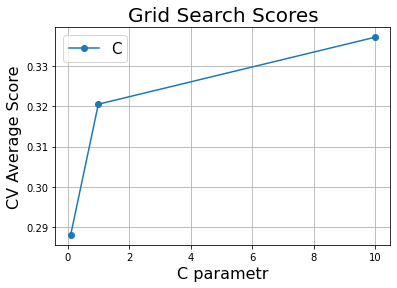

In [666]:
_, ax = plt.subplots(1,1)

ax.plot([0.1, 1, 10], grid_svm.cv_results_['mean_test_score'], '-o', label= 'C')
ax.set_title("Grid Search Scores", fontsize=20)
ax.set_xlabel('C parametr', fontsize=16)
ax.set_ylabel('CV Average Score', fontsize=16)
ax.legend(loc="best", fontsize=15)
ax.grid('on')

In [669]:
lrc = LinearSVC(C = 10, max_iter = 5000)
lrc.fit(train[:,:-1], targets)

preds = lrc.predict(testrd)
CountMetrics(test_targets, preds)

Accuracy score : 0.2973028437408385
Balanced accuracy score : 0.22901795573570324
F1 : 0.23328298197514846


In [674]:
len(train_targets[train_targets == 0])

297

In [686]:
preds = lrc.predict(train[:,:-1])
CountMetrics(targets, preds)

Accuracy score : 0.6488091760627835
Balanced accuracy score : 0.6037054027133667
F1 : 0.6291269671945684


In [689]:
testrd, test_targets

(<34110x5639 sparse matrix of type '<class 'numpy.float64'>'
 	with 4056003 stored elements in Compressed Sparse Column format>,
 array([  0,   0,   0, ..., 149, 149, 149]))

In [691]:
len(test_targets[test_targets == 0])

98

Попробуем идентифицировать конкретного пользователя

In [692]:
preds = lrc.predict(testrd[:98])
CountMetrics(test_targets[:98], preds)

Accuracy score : 0.2755102040816326
Balanced accuracy score : 0.2755102040816326
F1 : 0.022736842105263156


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
